# Visualizing 3d $\to$ 3d maps with deep networks

Generate random networks that maps inputs $(x, y, c) \to (r, g, b)$. We vary $c$ over time to get cool movies!

This implementation uses $1\times1$ convolutional networks, so the input-output mapping is really just a fully connected neural network. If you increase the `filter_width` below you can play with more complex truly convolutional mappings.

## Setup
Make sure to add `keras` and `Theano` to your path.
You'll also need to install [`moviepy` ](http://zulko.github.io/moviepy/install.html)

This uses the super bleeding edge version of `keras-1.0` from [here](https://github.com/fchollet/keras/pull/2152)

Basic imports


In [1]:
import keras
import keras.backend as K
from matplotlib import cm

%pylab inline

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, CuDNN 3007)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def hard_tanh(x):
    return K.clip(x, -1.0, 1.0)

## Parameters to play with

In [3]:
# Size of the output image is img_size x img_size
img_size = 128
# Number of hidden layers
n_layers = 5
# Number of filters in each hidden layer
n_filters = 128
# Number of input channels
n_input_channels = 3
# Number of output channels
# Set to 3 for RGB outputs
n_output_channels = 3
# Convolutional filter size
filter_width = 1 
# Initial weight scaling
# Larger weight scaling leads to more saturated/higher contrast outputs
init_weight_scale = 2.0
# Colormap to use when output is 1 dimensional
scalar_cmap = cm.CMRmap
# Hidden layer activation function
conv_act_fn = hard_tanh
# Output activation function
out_act_fn = lambda x: 0.5 * (hard_tanh(x) + 1)

Custom initialization function. Using normal with standard deviation:  `init_weight_scale / sqrt(n_in)`

In [4]:
from keras.initializations import normal, orthogonal
def init_fn(shape, name=None):
    return normal(shape, init_weight_scale * 1.0 / np.sqrt(shape[1]), name)

## Generate the model

In [5]:
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation
from keras.models import Sequential
from keras.optimizers import SGD

conv_kwargs = dict(nb_row=filter_width, nb_col=filter_width, border_mode='valid', init=init_fn)

model = Sequential()
for i in xrange(n_layers):
    model.add(Convolution2D(n_filters, input_shape=(n_input_channels, None, None), **conv_kwargs))
    model.add(Activation(conv_act_fn))

model.add(Convolution2D(n_output_channels,  **conv_kwargs))
model.add(Activation(out_act_fn))

x = model.input
y = model.output
compute_output = K.function([x], y)

## Evaluate the model
Evaluate the model by scanning a 2d plane over the 3d input space

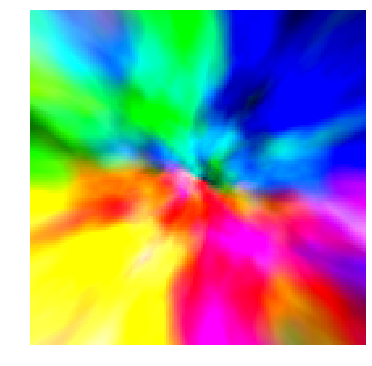

In [6]:
nframes = 200
scale = 1.0
x, y = (np.mgrid[:img_size, :img_size] / float(img_size)  * 2 - 1)  * scale
imgs = []
dxs = np.sin(np.linspace(0, 2 * np.pi, nframes))
for i, dx in enumerate(dxs):
    # Create (x, y, c) input
    xin = np.dstack((x, y, np.ones_like(x) *dx)).astype(np.float32).transpose(2, 0, 1)
    # Map through network
    img =  (compute_output((xin[None, ...],))[0].transpose(1,2,0)).squeeze()
    # Convert to RGB
    if img.ndim == 2:
        imgs.append(255 * cmap(img)[..., :3])
    else:
        imgs.append(img * 255.0)
    if i == 0: # Display the first image for debug purposes
        figure(figsize=(6,6))
        imshow(imgs[-1]/255., interpolation='nearest')
        axis('off')
        show()

## Visualize the model with moviepy

In [9]:
from moviepy.editor import ImageSequenceClip, ipython_display
clip = ImageSequenceClip(imgs, fps=20)
clip.ipython_display(loop=True)

## (Optional) Save results to an mp4

In [ ]:
clip.write_videofile("totally_rad_video_dude.mp4")

In [ ]:
clip.write_gif("super_cool.gif", fuzz=1, loop=True)